In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 10
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

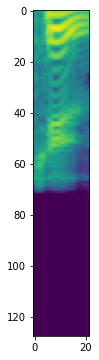

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9560055845709469
TEST
loss: 0.5289332582104591
accuracy: 0.8473118279569892
******************
epoch: 1
Train
0.38337717135875665
TEST
loss: 0.639070047358031
accuracy: 0.8301075268817204
******************
epoch: 2
Train
0.25619333613348955
TEST
loss: 0.3650265378336753
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.23243598416086544
TEST
loss: 0.5779141902923584
accuracy: 0.8258064516129032
******************
epoch: 4
Train
0.15063995090812268
TEST
loss: 0.27964311761240807
accuracy: 0.9161290322580645
******************
epoch: 5
Train
0.20681394051658125
TEST
loss: 0.31729032557497744
accuracy: 0.9010752688172043
******************
epoch: 6
Train
0.18246812082518155
TEST
loss: 0.5804109209327287
accuracy: 0.864516129032258
******************
epoch: 7
Train
0.1900091000507131
TEST
loss: 0.26539728500509774
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.1198857138249331
TEST
loss: 0.5104024088510903
accuracy: 0.8688172043010752
****

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


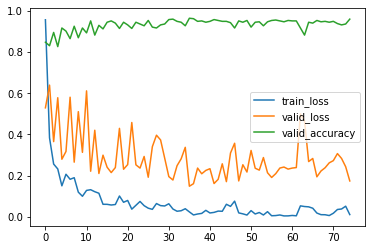

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0947767459518112
TEST
loss: 0.7932552460701235
accuracy: 0.810752688172043
******************
epoch: 1
Train
0.38974584554817066
TEST
loss: 0.7160011312013032
accuracy: 0.8172043010752689
******************
epoch: 2
Train
0.27993185839861007
TEST
loss: 0.39600304429249095
accuracy: 0.8817204301075269
******************
epoch: 3
Train
0.22854618247504124
TEST
loss: 0.30872321039117795
accuracy: 0.9032258064516129
******************
epoch: 4
Train
0.20966424916980725
TEST
loss: 0.2883329268424742
accuracy: 0.9053763440860215
******************
epoch: 5
Train
0.19635588728296674
TEST
loss: 0.26510782857095044
accuracy: 0.9311827956989247
******************
epoch: 6
Train
0.13633371759196025
TEST
loss: 0.24805367339041925
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.16105862981732583
TEST
loss: 0.33699337000487956
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.13823741956879262
TEST
loss: 0.510096249272746

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


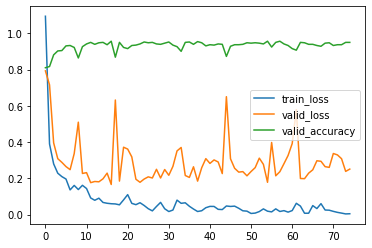

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0965767237982187
TEST
loss: 0.7729003613994968
accuracy: 0.7225806451612903
******************
epoch: 1
Train
0.42351241463541534
TEST
loss: 0.435932065979127
accuracy: 0.8688172043010752
******************
epoch: 2
Train
0.3475843986389004
TEST
loss: 0.49688455315046415
accuracy: 0.8709677419354839
******************
epoch: 3
Train
0.35765074367605365
TEST
loss: 0.33693777899588306
accuracy: 0.9053763440860215
******************
epoch: 4
Train
0.24398351845461383
TEST
loss: 0.27142661733012047
accuracy: 0.9247311827956989
******************
epoch: 5
Train
0.2018998567422167
TEST
loss: 0.29501164126139817
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.17018159255425522
TEST
loss: 0.25048347250107794
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.18138960756534006
TEST
loss: 0.34254751923263715
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.17122013941928785
TEST
loss: 0.3563510757620616

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


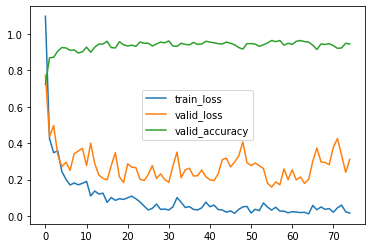

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.023146394381423
TEST
loss: 0.861247545160273
accuracy: 0.7505376344086021
******************
epoch: 1
Train
0.40639634869338753
TEST
loss: 0.49679026936972015
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.2749198008174208
TEST
loss: 0.529601937724698
accuracy: 0.8365591397849462
******************
epoch: 3
Train
0.22418583957623844
TEST
loss: 0.2693245873656324
accuracy: 0.9161290322580645
******************
epoch: 4
Train
0.19148052574873098
TEST
loss: 0.39207646616043584
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.2086062872993991
TEST
loss: 0.26063853040818247
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.1427165854664085
TEST
loss: 0.39583753212805717
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.16850490946729912
TEST
loss: 0.46003794849559826
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.18611993778278318
TEST
loss: 0.2863811997957127
accu

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


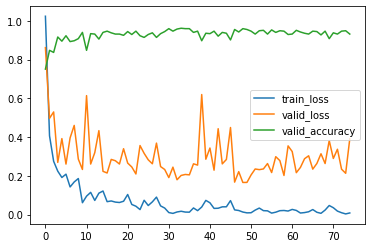

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9869705545818799
TEST
loss: 0.6350480133487332
accuracy: 0.8172043010752689
******************
epoch: 1
Train
0.39875912088569804
TEST
loss: 0.31232636590157786
accuracy: 0.8989247311827957
******************
epoch: 2
Train
0.21774679252262968
TEST
loss: 0.3376177728817027
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.224137782344397
TEST
loss: 0.9195135813887402
accuracy: 0.7741935483870968
******************
epoch: 4
Train
0.20622960065216164
TEST
loss: 0.2915539227506166
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.15029513402593733
TEST
loss: 0.442604189021613
accuracy: 0.8795698924731182
******************
epoch: 6
Train
0.20605652100082103
TEST
loss: 0.515914261212913
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.13870480674277344
TEST
loss: 0.5398010788425323
accuracy: 0.8795698924731182
******************
epoch: 8
Train
0.1861246728694882
TEST
loss: 0.25092890567036086
accurac

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


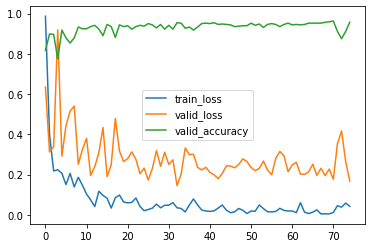

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.105691268871597
TEST
loss: 0.4151371527743596
accuracy: 0.8602150537634409
******************
epoch: 1
Train
0.4120567285314836
TEST
loss: 0.32701575268981276
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.29061014323576073
TEST
loss: 0.6481681231529483
accuracy: 0.8193548387096774
******************
epoch: 3
Train
0.2719591692306691
TEST
loss: 0.21311862949402102
accuracy: 0.9333333333333333
******************
epoch: 4
Train
0.19333526028313172
TEST
loss: 0.31698228357940594
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.23217620782847037
TEST
loss: 0.5330613569546772
accuracy: 0.8709677419354839
******************
epoch: 6
Train
0.2365670624155477
TEST
loss: 0.4081283325790077
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.18535259165427476
TEST
loss: 0.2527643324226461
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.17786353528820575
TEST
loss: 0.23148281433249032
ac

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


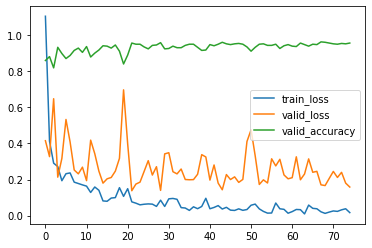

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.850332736712216
TEST
loss: 2.4686206284389702
accuracy: 0.4344086021505376
******************
epoch: 1
Train
1.3552608479719106
TEST
loss: 0.8743874385792721
accuracy: 0.7182795698924731
******************
epoch: 2
Train
1.21650654099998
TEST
loss: 0.7364410261954031
accuracy: 0.7634408602150538
******************
epoch: 3
Train
1.143495929067855
TEST
loss: 0.6713174977610188
accuracy: 0.7784946236559139
******************
epoch: 4
Train
1.0078663800310947
TEST
loss: 0.8103920095710344
accuracy: 0.8086021505376344
******************
epoch: 5
Train
1.0203257232310634
TEST
loss: 0.6073576838739456
accuracy: 0.8451612903225807
******************
epoch: 6
Train
0.9839748675038754
TEST
loss: 0.6711248569591071
accuracy: 0.821505376344086
******************
epoch: 7
Train
1.002442415003245
TEST
loss: 0.329847627557734
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.9480634642083862
TEST
loss: 1.4059685271273377
accuracy: 0.74408

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9259896729776248


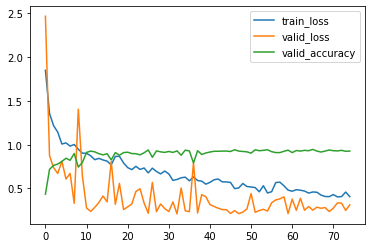

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.6162484643532502
TEST
loss: 2.2519870260710357
accuracy: 0.33763440860215055
******************
epoch: 1
Train
0.7767177553798283
TEST
loss: 0.9223350773575485
accuracy: 0.7053763440860215
******************
epoch: 2
Train
0.494493787238594
TEST
loss: 3.0743324310548843
accuracy: 0.2860215053763441
******************
epoch: 3
Train
0.4227894732691488
TEST
loss: 1.0656674272270612
accuracy: 0.7225806451612903
******************
epoch: 4
Train
0.3383161719922552
TEST
loss: 0.6793781379217743
accuracy: 0.7849462365591398
******************
epoch: 5
Train
0.385637944657506
TEST
loss: 0.6265964974639237
accuracy: 0.8387096774193549
******************
epoch: 6
Train
0.28722450061709764
TEST
loss: 0.5558381990719867
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.3529431644022689
TEST
loss: 0.3200490367028021
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.2446258983820051
TEST
loss: 0.38850880771554924
accuracy: 

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9208261617900172


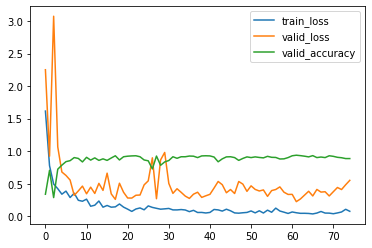

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9920032665045209
TEST
loss: 0.7071058662988806
accuracy: 0.8279569892473119
******************
epoch: 1
Train
0.3870384058903544
TEST
loss: 0.3564713856225373
accuracy: 0.8838709677419355
******************
epoch: 2
Train
0.278647066350258
TEST
loss: 0.6982257017525294
accuracy: 0.8
******************
epoch: 3
Train
0.24434835803592211
TEST
loss: 0.2959433189643327
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.19968629417781492
TEST
loss: 0.4454186694596403
accuracy: 0.875268817204301
******************
epoch: 5
Train
0.20109103078410775
TEST
loss: 0.3514303538107103
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.15694804816202382
TEST
loss: 0.3363942664156678
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.1299029953645389
TEST
loss: 0.22459458343444333
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.11468087664344456
TEST
loss: 0.49769645198698964
accuracy: 0.86236559

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


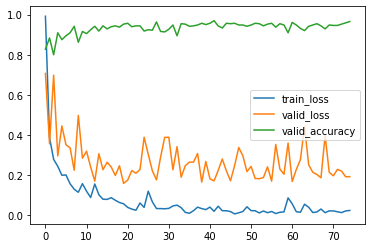

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9718151568852899
TEST
loss: 0.7957775777386081
accuracy: 0.7784946236559139
******************
epoch: 1
Train
0.34996942094916866
TEST
loss: 0.3694795846939087
accuracy: 0.896774193548387
******************
epoch: 2
Train
0.23056907045886152
TEST
loss: 0.3509816506857513
accuracy: 0.8924731182795699
******************
epoch: 3
Train
0.25700049934428293
TEST
loss: 0.3958740156183961
accuracy: 0.8774193548387097
******************
epoch: 4
Train
0.21519773357583427
TEST
loss: 0.37255452256048877
accuracy: 0.8903225806451613
******************
epoch: 5
Train
0.20422669505328342
TEST
loss: 0.39144700150335987
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.12688285146083123
TEST
loss: 0.2791028409875849
accuracy: 0.9139784946236559
******************
epoch: 7
Train
0.11620757882480796
TEST
loss: 0.29197963604363064
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.1012671042673037
TEST
loss: 0.21923759836022572


In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


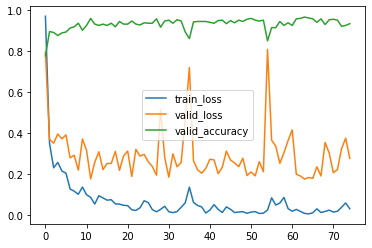

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0111132145698314
TEST
loss: 0.6355216969725906
accuracy: 0.7763440860215054
******************
epoch: 1
Train
0.4339667520795256
TEST
loss: 0.3724806834292668
accuracy: 0.8881720430107527
******************
epoch: 2
Train
0.32355411295359277
TEST
loss: 0.40693880511868386
accuracy: 0.8666666666666667
******************
epoch: 3
Train
0.25941590153535465
TEST
loss: 0.6233741639762796
accuracy: 0.8451612903225807
******************
epoch: 4
Train
0.2180570176550311
TEST
loss: 0.22973849452951903
accuracy: 0.9096774193548387
******************
epoch: 5
Train
0.22176011974733237
TEST
loss: 0.3318953159034893
accuracy: 0.8903225806451613
******************
epoch: 6
Train
0.19524381749079184
TEST
loss: 0.22948286456446493
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.1483684336875932
TEST
loss: 0.3951481755061816
accuracy: 0.8924731182795699
******************
epoch: 8
Train
0.25103257982462535
TEST
loss: 0.31133251433731407
a

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


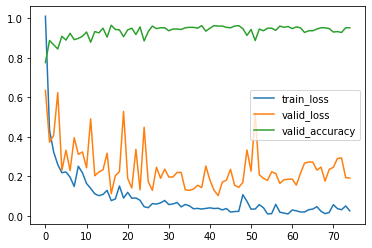

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.8635934805061205
TEST
loss: 1.2156741898546937
accuracy: 0.6172043010752688
******************
epoch: 1
Train
1.3545744994281117
TEST
loss: 0.5539757351721487
accuracy: 0.810752688172043
******************
epoch: 2
Train
1.2232613270810424
TEST
loss: 0.5992320604221795
accuracy: 0.8408602150537634
******************
epoch: 3
Train
1.1406129119084225
TEST
loss: 0.733959972986611
accuracy: 0.7591397849462366
******************
epoch: 4
Train
1.0192859601640676
TEST
loss: 0.5431221728683799
accuracy: 0.853763440860215
******************
epoch: 5
Train
1.0148108985132598
TEST
loss: 0.5669360624846592
accuracy: 0.853763440860215
******************
epoch: 6
Train
1.0090154945433107
TEST
loss: 0.6562902376215946
accuracy: 0.8064516129032258
******************
epoch: 7
Train
0.9950432783824241
TEST
loss: 0.3480577435544742
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.9148322326493764
TEST
loss: 0.5235604730985498
accuracy: 0.866

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


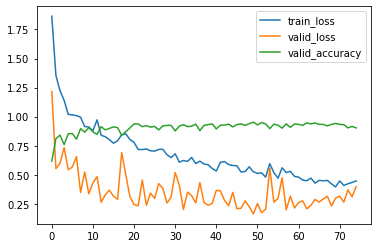

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9390134193849743
TEST
loss: 0.6630551379214051
accuracy: 0.8236559139784946
******************
epoch: 1
Train
0.4212472759785033
TEST
loss: 0.5964419021401354
accuracy: 0.810752688172043
******************
epoch: 2
Train
0.28970329146521284
TEST
loss: 0.4148204365084248
accuracy: 0.8559139784946237
******************
epoch: 3
Train
0.3134379739971911
TEST
loss: 0.581621144663903
accuracy: 0.8516129032258064
******************
epoch: 4
Train
0.2659057818501626
TEST
loss: 0.3153928763122969
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.1892135541607246
TEST
loss: 0.38179951803658596
accuracy: 0.886021505376344
******************
epoch: 6
Train
0.20423978692302797
TEST
loss: 0.35827299010369085
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.1838676023688699
TEST
loss: 0.2692658603191376
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.16099881578595907
TEST
loss: 0.26838554890565974
accurac

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


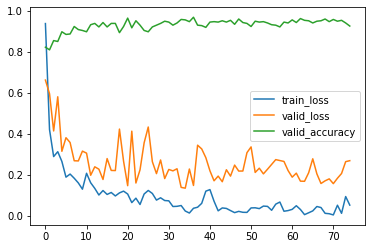

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.8188360161080306
TEST
loss: 1.0539787756499424
accuracy: 0.6537634408602151
******************
epoch: 1
Train
1.3693075920858881
TEST
loss: 0.7689627734563684
accuracy: 0.7569892473118279
******************
epoch: 2
Train
1.2417125673658693
TEST
loss: 0.58928199250211
accuracy: 0.8344086021505376
******************
epoch: 3
Train
1.139535711860554
TEST
loss: 0.7006902704956711
accuracy: 0.7784946236559139
******************
epoch: 4
Train
1.020408492994745
TEST
loss: 0.7695777736684327
accuracy: 0.7870967741935484
******************
epoch: 5
Train
1.0474224188151897
TEST
loss: 0.2791792352994283
accuracy: 0.9032258064516129
******************
epoch: 6
Train
1.0079908751003448
TEST
loss: 0.6785053668483612
accuracy: 0.7806451612903226
******************
epoch: 7
Train
1.006455320790691
TEST
loss: 0.3702597157929533
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.9484244857864093
TEST
loss: 0.41162072074028755
accuracy: 0.89

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


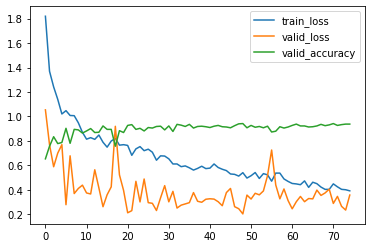

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9235148375947179
TEST
loss: 0.6578169402255807
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.3481586836458986
TEST
loss: 0.4241947780373276
accuracy: 0.8516129032258064
******************
epoch: 2
Train
0.24403003241724394
TEST
loss: 0.3384841765126874
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.24459384212457946
TEST
loss: 0.7027788321177165
accuracy: 0.8688172043010752
******************
epoch: 4
Train
0.20031700265234237
TEST
loss: 0.979719384767676
accuracy: 0.789247311827957
******************
epoch: 5
Train
0.1682399407101371
TEST
loss: 0.2405400215938527
accuracy: 0.9333333333333333
******************
epoch: 6
Train
0.14535038350536159
TEST
loss: 0.3467317404285554
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.1575186849523117
TEST
loss: 0.4420891830998082
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.1671877921301637
TEST
loss: 0.4905960782881706
accuracy:

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


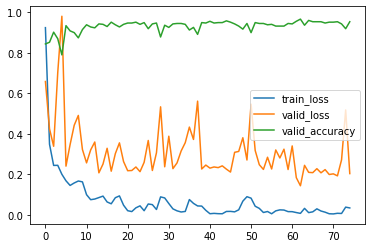

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0148448818270468
TEST
loss: 0.5255018223998367
accuracy: 0.832258064516129
******************
epoch: 1
Train
0.4658897422498827
TEST
loss: 0.5328561782836914
accuracy: 0.843010752688172
******************
epoch: 2
Train
0.31164529083490244
TEST
loss: 0.3346747281730816
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.27540055570515115
TEST
loss: 0.5223857459201607
accuracy: 0.853763440860215
******************
epoch: 4
Train
0.25565894419105706
TEST
loss: 0.3213533001561319
accuracy: 0.8881720430107527
******************
epoch: 5
Train
0.21298790664909087
TEST
loss: 0.2846413667483996
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.18458364596595414
TEST
loss: 0.15962670272396456
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.1589011113587155
TEST
loss: 0.29363815592181297
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.22226849893247433
TEST
loss: 0.23527983785957418
accur

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


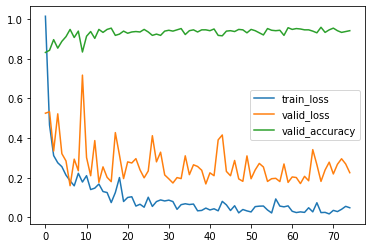

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9778649135501268
TEST
loss: 0.4874876688885432
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.3778045580601525
TEST
loss: 0.46653938870276174
accuracy: 0.8559139784946237
******************
epoch: 2
Train
0.266433902626469
TEST
loss: 0.30338376055481614
accuracy: 0.9247311827956989
******************
epoch: 3
Train
0.23312144198915813
TEST
loss: 0.43870991558156985
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.16124674281447435
TEST
loss: 0.520006803543337
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.1866731719747306
TEST
loss: 0.27964471950325914
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.17961413817310692
TEST
loss: 0.30824356040646955
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.16471765961901244
TEST
loss: 0.3530449758293808
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.16307031484014833
TEST
loss: 0.26375184212961506
acc

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


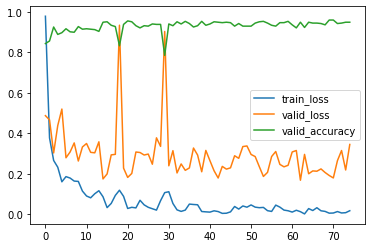

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0203575978820916
TEST
loss: 0.9551789096606675
accuracy: 0.7290322580645161
******************
epoch: 1
Train
0.4068081528510082
TEST
loss: 0.6566417876110282
accuracy: 0.8043010752688172
******************
epoch: 2
Train
0.31489283498025544
TEST
loss: 0.2838040905614053
accuracy: 0.9075268817204301
******************
epoch: 3
Train
0.3135637996911874
TEST
loss: 0.4968784493784751
accuracy: 0.8731182795698925
******************
epoch: 4
Train
0.18295862181057004
TEST
loss: 0.32800525093591343
accuracy: 0.9075268817204301
******************
epoch: 5
Train
0.2037428587787435
TEST
loss: 0.30705589620015955
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.1951492088548458
TEST
loss: 0.26683190086836456
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.18530779714281354
TEST
loss: 0.30209458630572084
accuracy: 0.9118279569892473
******************
epoch: 8
Train
0.19415301371789068
TEST
loss: 0.2806585955363448
ac

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


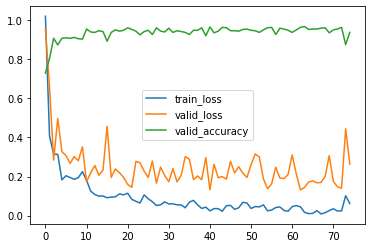

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9782688412283721
TEST
loss: 0.5075042370826968
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.3793479800545277
TEST
loss: 0.28990075460044284
accuracy: 0.9010752688172043
******************
epoch: 2
Train
0.2676369074409086
TEST
loss: 0.4696984883277647
accuracy: 0.8709677419354839
******************
epoch: 3
Train
0.24963764452330836
TEST
loss: 0.39662821126240555
accuracy: 0.8924731182795699
******************
epoch: 4
Train
0.20639749342353997
TEST
loss: 0.23491141296202137
accuracy: 0.9225806451612903
******************
epoch: 5
Train
0.18932309006899997
TEST
loss: 0.24585116524850167
accuracy: 0.9354838709677419
******************
epoch: 6
Train
0.1259909287901514
TEST
loss: 0.19142154339821107
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.161601364905467
TEST
loss: 0.24380259616400607
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.14664448800110086
TEST
loss: 0.3204249102582214
ac

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


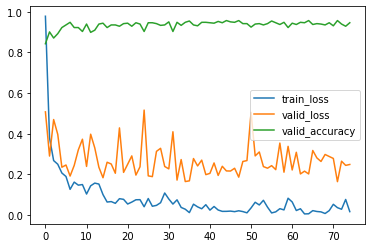

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.3064374980197264
TEST
loss: 1.2886672430140997
accuracy: 0.7032258064516129
******************
epoch: 1
Train
0.6042553637704351
TEST
loss: 0.6548385076625373
accuracy: 0.8344086021505376
******************
epoch: 2
Train
0.4028970618753839
TEST
loss: 0.666387056022562
accuracy: 0.8086021505376344
******************
epoch: 3
Train
0.41573765936498686
TEST
loss: 0.44092647157689574
accuracy: 0.853763440860215
******************
epoch: 4
Train
0.3532003171352783
TEST
loss: 0.3395392826808396
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.32598151631681394
TEST
loss: 0.4275994546951786
accuracy: 0.8709677419354839
******************
epoch: 6
Train
0.27453156094045233
TEST
loss: 0.4594647612622989
accuracy: 0.8709677419354839
******************
epoch: 7
Train
0.3206415095506462
TEST
loss: 0.33762376808351086
accuracy: 0.9032258064516129
******************
epoch: 8
Train
0.2842924902371071
TEST
loss: 0.6624684154346425
accurac

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


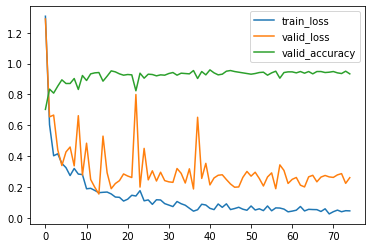

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()